## FD_abs[hbo2] ANN Fitting

In [12]:
import sys
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import glob
import os
import numpy as np
import sys
import pickle
from tqdm import tqdm
! pip install pmcx
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import StandardScaler

### Read the saved CSV

In [14]:
import pandas as pd
import glob
import numpy as np
import sys
! pip install pmcx
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
csv_path = '/content/drive/MyDrive/MCX_data/stage2_train.csv'
final_array = np.loadtxt(csv_path, delimiter=',')
print(final_array.shape)
X_train = final_array
#
csv_path_test = '/content/drive/MyDrive/MCX_data/stage2_test.csv'
final_array = np.loadtxt(csv_path_test, delimiter=',')
print(final_array.shape)
X_test = final_array

(10000, 192)
(1000, 192)


### GT

In [16]:
GT_folder_train = '/content/drive/MyDrive/MCX_data/stage2_csv/'
GT_folder_test = '/content/drive/MyDrive/MCX_data/test_csv/'

In [17]:
csv_files_train = glob.glob(os.path.join(GT_folder_train, '*.csv'))
GT_all_train = pd.concat([pd.read_csv(f) for f in csv_files_train], ignore_index=True)
csv_files_test = glob.glob(os.path.join(GT_folder_test, '*.csv'))
GT_all_test = pd.concat([pd.read_csv(f) for f in csv_files_test], ignore_index=True)

In [18]:
sorted_ids = [i+1 for i in range(10000)]
GT_all_train['ID'] = GT_all_train['ID'].astype(int)
GT_filtered = GT_all_train[GT_all_train['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()
Y = GT_filtered['HHB1'].values
y_train = Y.reshape(-1, 1)

In [19]:
sorted_ids = [i+1 for i in range(1000)]
GT_all_test['ID'] = GT_all_test['ID'].astype(int)
GT_filtered = GT_all_test[GT_all_test['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()
Y = GT_filtered['HHB1'].values
y_test = Y.reshape(-1, 1)

In [20]:
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)
X_train = scaler_X.transform(X_train)
X_test  = scaler_X.transform(X_test)
Y_train = scaler_y.transform(y_train)
Y_test = scaler_y.transform(y_test)

In [21]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(10000, 192) (1000, 192) (10000, 1) (1000, 1)


### ANN

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.losses import Huber
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from pathlib import Path
import joblib, tensorflow as tf
WEIGHT_DIR = Path("/content/drive/MyDrive/MCX_data/weights")

model = Sequential([
    Input(shape=(192,)),
    Dense(1000, activation='relu'),
    Dropout(0.1),

    Dense(4096, activation='relu'),
    Dropout(0.1),

    Dense(4096, activation='relu'),
    Dropout(0.2),

    Dense(8192, activation='relu'),
    Dropout(0.2),

    Dense(8192*2, activation='relu'),
    Dropout(0.2),

    Dense(8192, activation='relu'),
    Dropout(0.2),

    Dense(4096, activation='relu'),
    Dropout(0.2),

    Dense(2048, activation='relu'),
    Dropout(0.2),

    Dense(1024, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.1),

    Dense(256, activation='relu'),
    Dropout(0.1),

    Dense(64, activation='relu'),
    Dropout(0.1),

    Dense(32, activation='relu'),
    Dropout(0.0),

    Dense(1) 
])

checkpoint_cb = ModelCheckpoint(
    "FD_hhb1_ANN.keras",        # filepath to save to
    monitor="val_loss",     # quantity to monitor
    mode="min",             # we want to minimize val_loss
    save_best_only=True,    # only save when val_loss decreases
    save_weights_only=False # set True if you only want weights
)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss="mse")

history = model.fit(
    X_train, Y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint_cb]
)

model = tf.keras.models.load_model("FD_hhb1_ANN.keras")

Epoch 1/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 66s 198ms/step - loss: 0.9852 - val_loss: 0.6424
Epoch 2/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - loss: 0.5233 - val_loss: 0.3502
Epoch 3/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.4059 - val_loss: 0.3746
Epoch 4/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.3318 - val_loss: 0.3504
Epoch 5/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 27s 98ms/step - loss: 0.3188 - val_loss: 0.3029
Epoch 6/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - loss: 0.2867 - val_loss: 0.2463
Epoch 7/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - loss: 0.2602 - val_loss: 0.2336
Epoch 8/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - loss: 0.2572 - val_loss: 0.2053
Epoch 9/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.2434 - val_loss: 0.2226
Epoch 10/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.2285 - val_loss: 0.2207
Epoch 11/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1906 - val_loss: 0.2312
Epoch 12/200
282/282 ━━

In [23]:
WEIGHT_DIR = Path("/content/drive/MyDrive/MCX_data/weights")
WEIGHT_DIR.mkdir(parents=True, exist_ok=True)
model_path = WEIGHT_DIR / "FD_hhb1_ANN.keras"
model.save(model_path)
joblib.dump(scaler_X, WEIGHT_DIR / "X_FD_hhb1_ANN.pkl")
joblib.dump(scaler_y, WEIGHT_DIR / "Y_FD_hhb1_ANN.pkl")
print("model file exists:", model_path.exists(),
      "size =", model_path.stat().st_size/1e6, "MB")

model file exists: True size = 4413.93751 MB


In [24]:
y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step
Test MSE: 0.0404


In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 1000)           │       193,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4096)           │     4,100,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8192)           │    33,562,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16384)          │   134,234,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8192)           │   134,225,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,08

 Total params: 1,103,457,341 (4.11 GB)

 Trainable params: 367,819,113 (1.37 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 735,638,228 (2.74 GB)

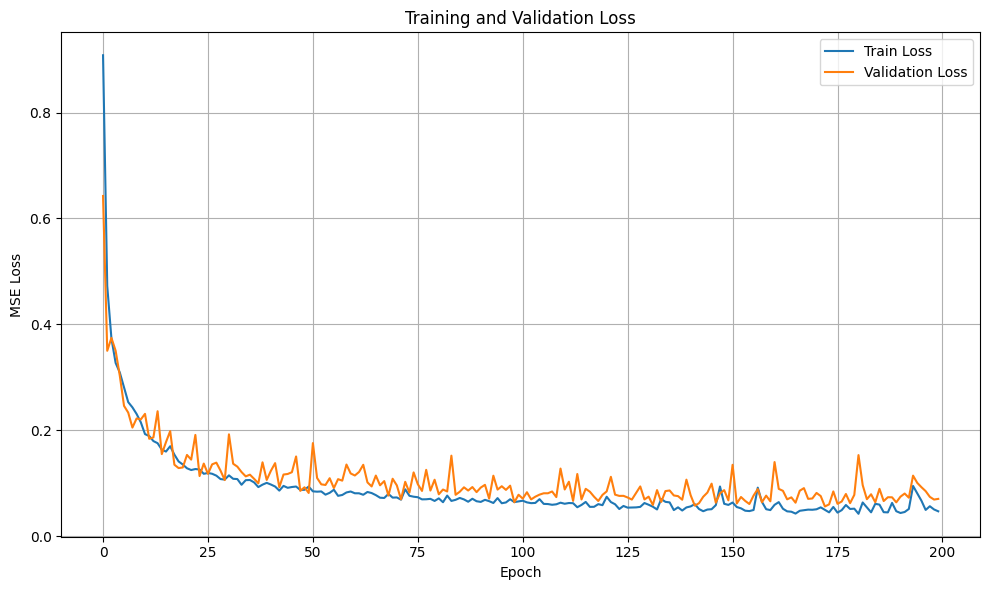

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Test MSE: 0.3367


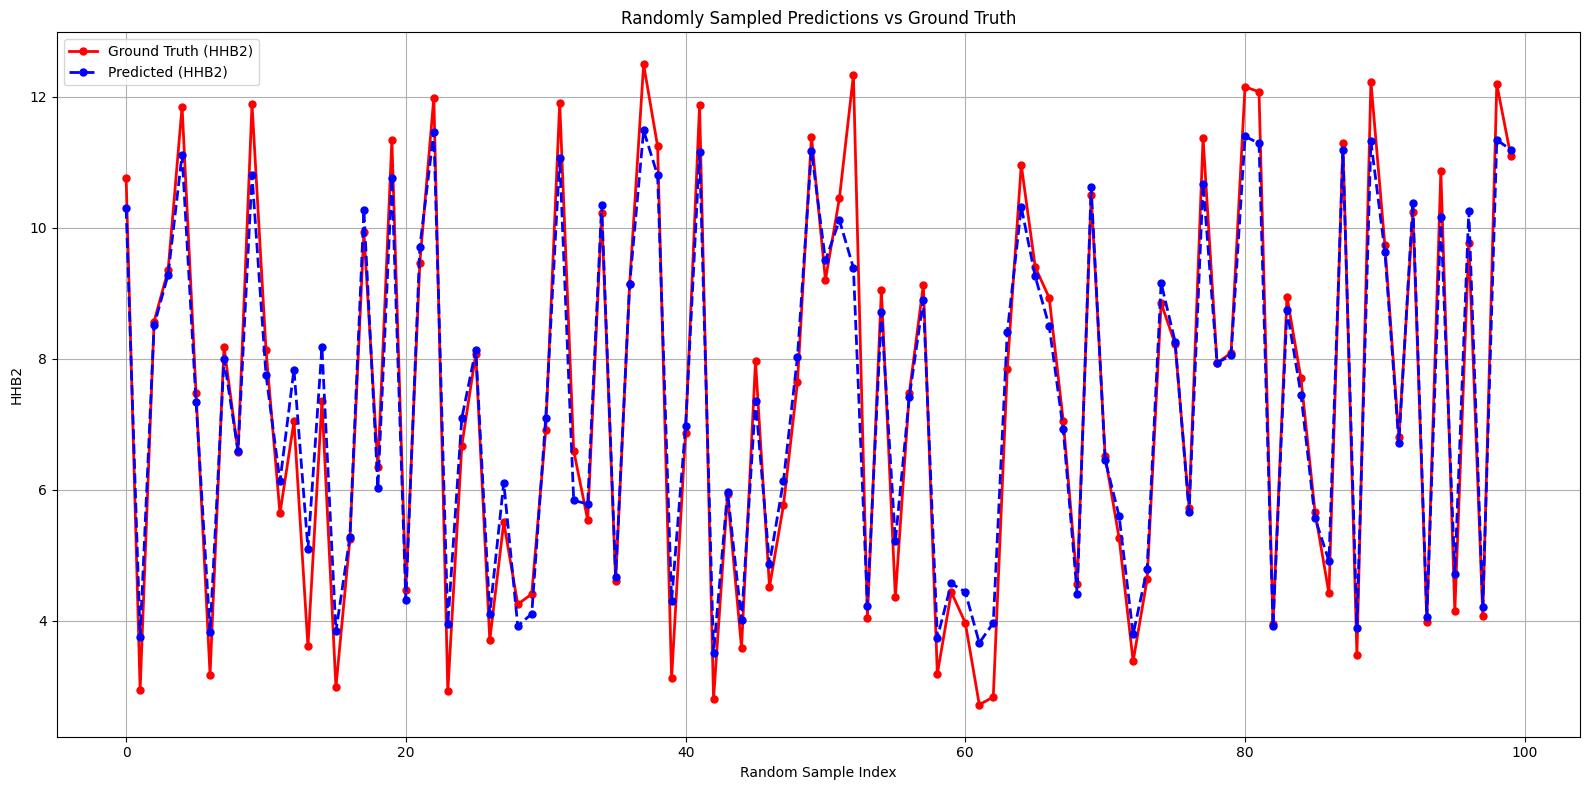

In [27]:

import matplotlib.pyplot as plt
indices = np.random.choice(len(Y_test), size=100, replace=False)
indices = np.sort(indices)

y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f"Test MSE: {mse:.4f}")
y_test_sampled = y_test_rescaled[indices]
y_pred_sampled = y_pred_rescaled[indices]

plt.figure(figsize=(16, 8))
plt.plot(y_test_sampled, 'r-o', label='Ground Truth (HHB2)', linewidth=2, markersize=5)
plt.plot(y_pred_sampled, 'b--o', label='Predicted (HHB2)', linewidth=2, markersize=5)
plt.xlabel('Random Sample Index')
plt.ylabel('HHB2')
plt.title('Randomly Sampled Predictions vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Test MSE (original scale): 0.3367


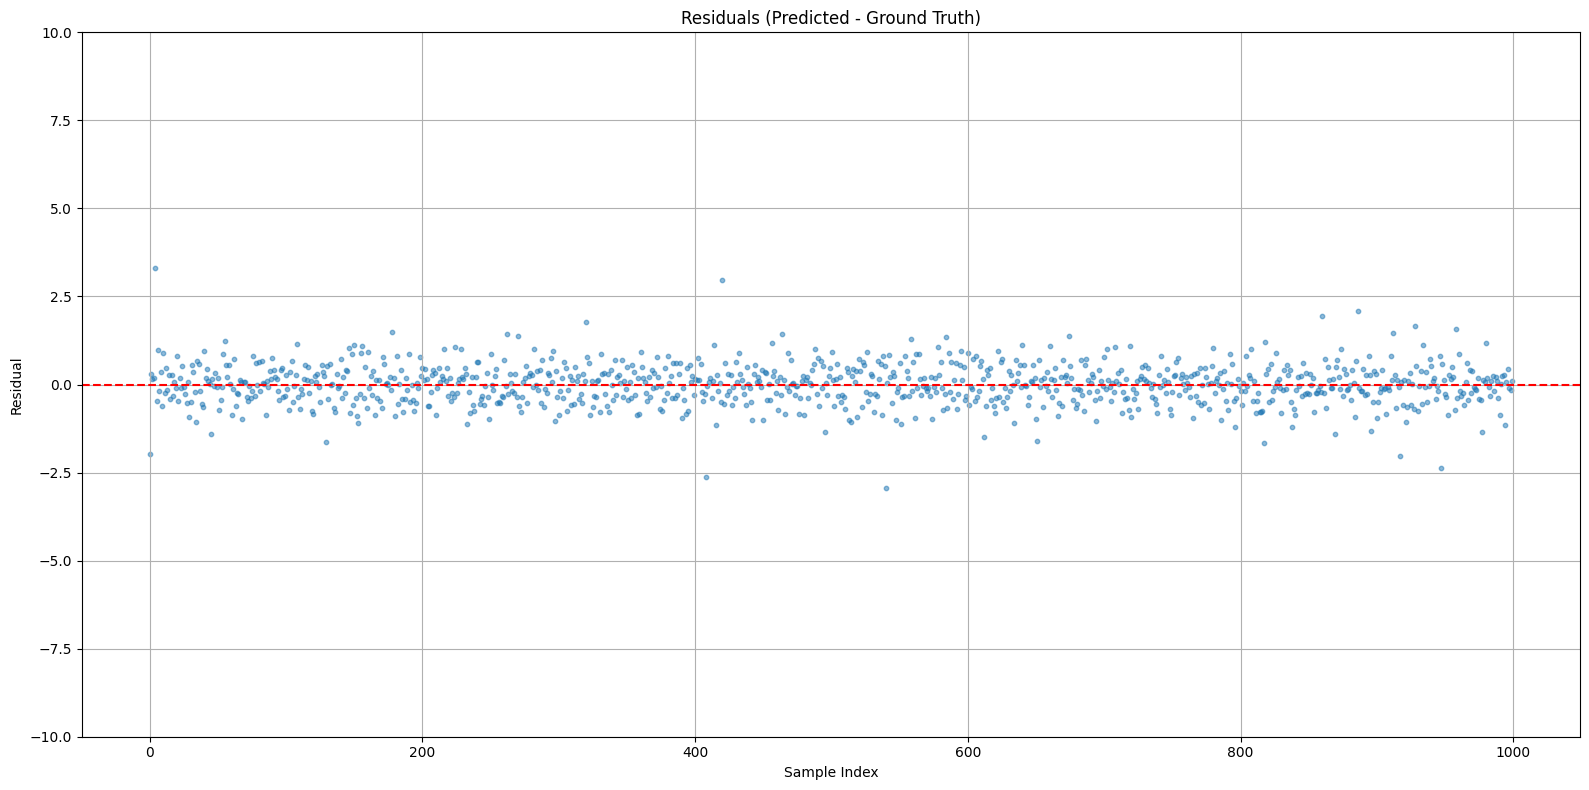

In [28]:
y_pred_orig = scaler_y.inverse_transform(y_pred)    
y_test_orig = scaler_y.inverse_transform(Y_test)   
residuals = y_pred_orig - y_test_orig

mse_rescaled = mean_squared_error(y_test_orig, y_pred_orig)
print(f"Test MSE (original scale): {mse_rescaled:.4f}")

# Plot residuals
plt.figure(figsize=(16, 8))
plt.scatter(range(len(residuals)), residuals, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals (Predicted - Ground Truth)")
plt.ylabel("Residual")
plt.ylim(-10, 10)
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()

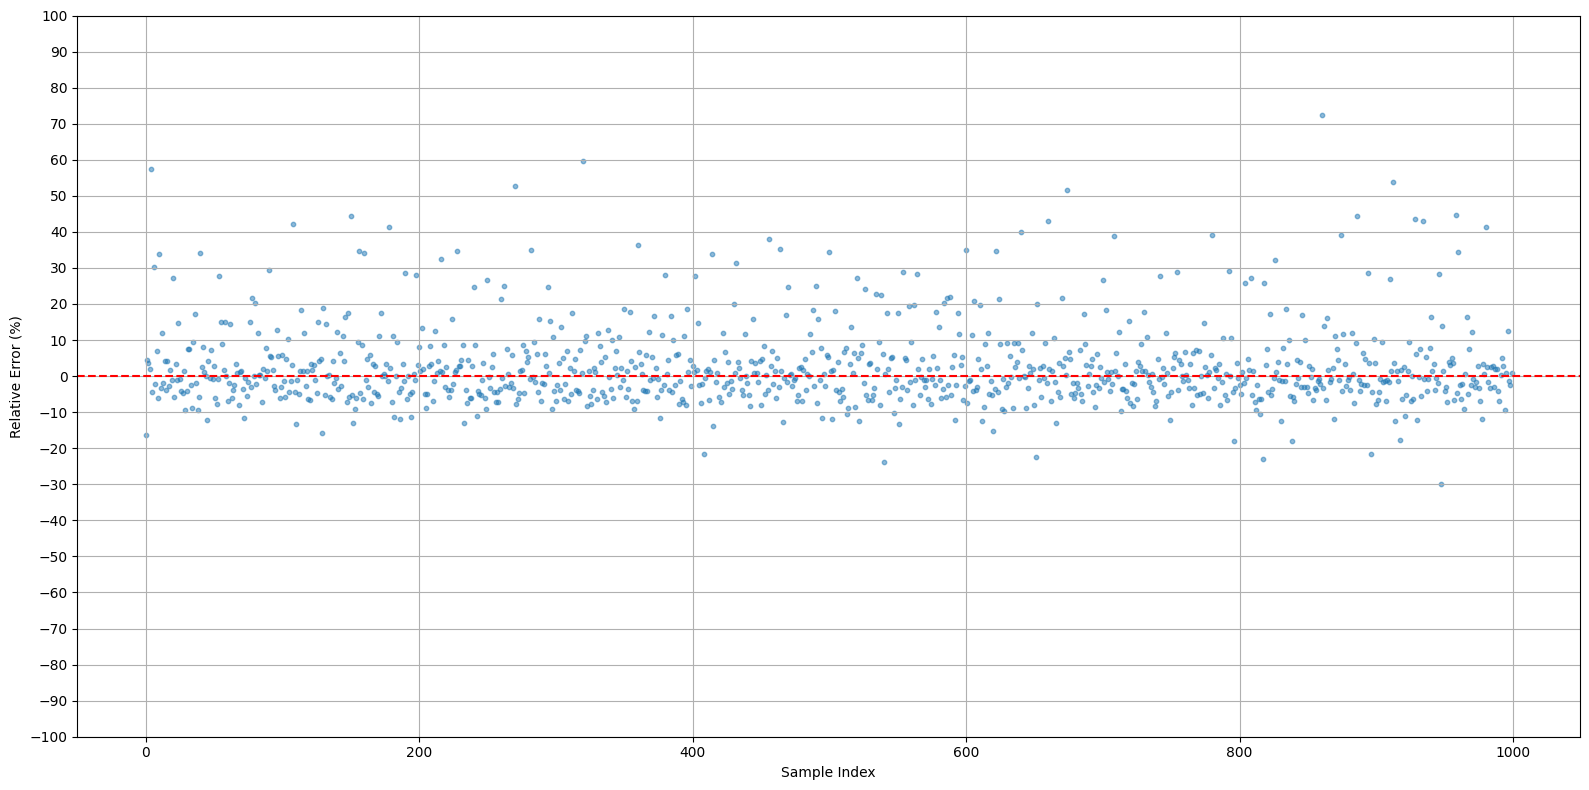

In [29]:
y_pred_orig = scaler_y.inverse_transform(y_pred)       # shape (n, 1)
y_test_orig = scaler_y.inverse_transform(Y_test)     # shape (n, 1)
relative_error = ((y_pred_orig - y_test_orig) / y_test_orig) * 100
plt.figure(figsize=(16, 8))
plt.scatter(range(len(relative_error)), relative_error, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.ylabel("Relative Error (%)")
plt.ylim(-100, 100)
plt.yticks(np.arange(-100, 101, 10))
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()


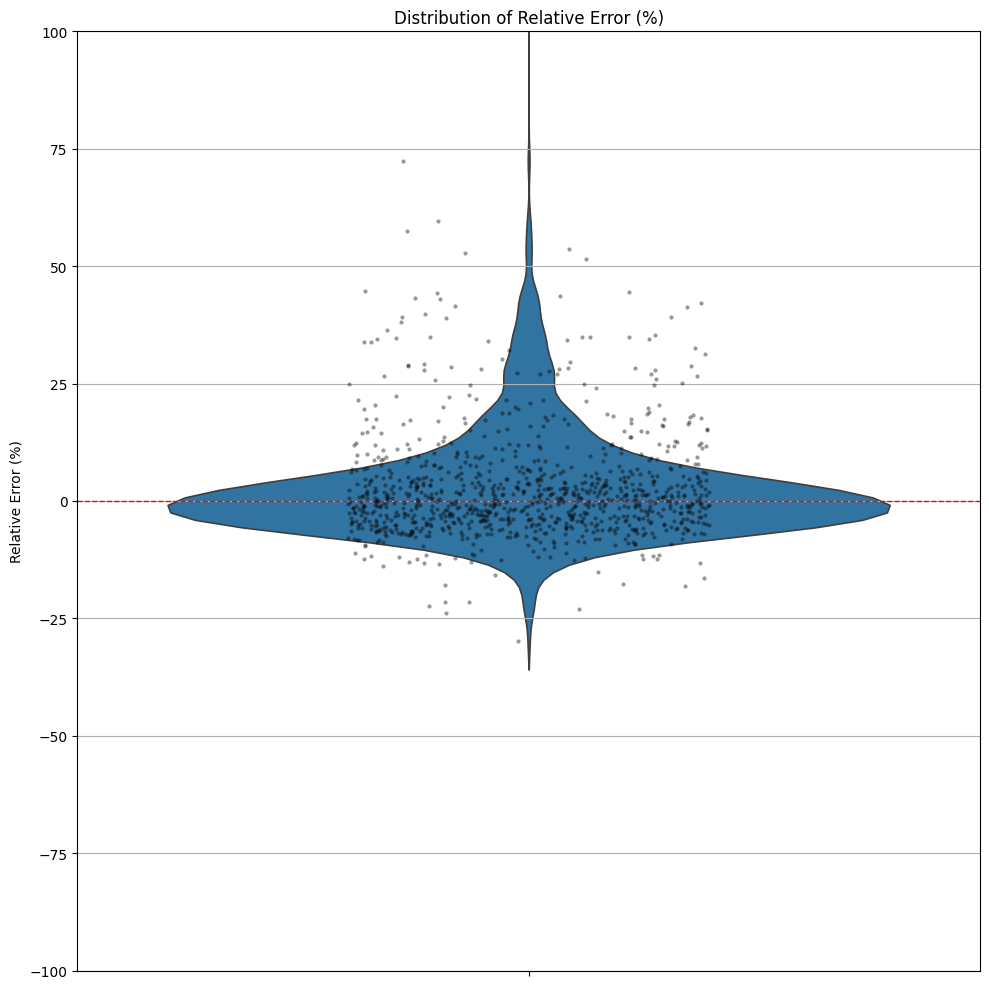

In [30]:
import seaborn as sns
df_plot = pd.DataFrame({
    'Relative Error (%)': relative_error.flatten()
})

plt.figure(figsize=(10, 10))
sns.violinplot(data=df_plot, y='Relative Error (%)', inner=None, linewidth=1.2)
sns.stripplot(data=df_plot, y='Relative Error (%)', color='black', alpha=0.4, jitter=0.2, size=3)

plt.axhline(0, color='r', linestyle='--', linewidth=1)
plt.ylim(-100, 100)
plt.title('Distribution of Relative Error (%)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


R² = 0.9595999175262546
MAPE = 7.604543621498319 %


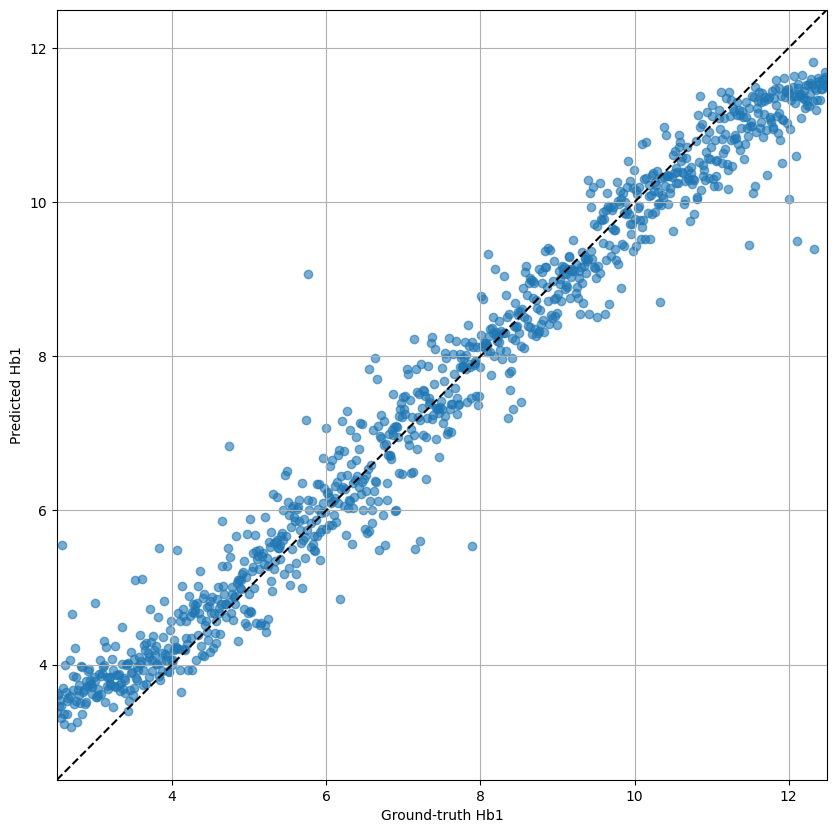

In [41]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
plt.figure(figsize=(10,10))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.6)
lims = [min(y_test_rescaled.min(), y_pred_rescaled.min()),
        max(y_test_rescaled.max(), y_pred_rescaled.max())]
plt.plot(lims, lims, 'k--')              # identity line
plt.xlabel('Ground-truth Hb1'); plt.ylabel('Predicted Hb1')
plt.axis('square'); plt.xlim(lims); plt.ylim(lims)
plt.grid()
print("R² =", r2_score(y_test_rescaled, y_pred_rescaled))
print("MAPE =", mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)*100, "%")
plt.show()

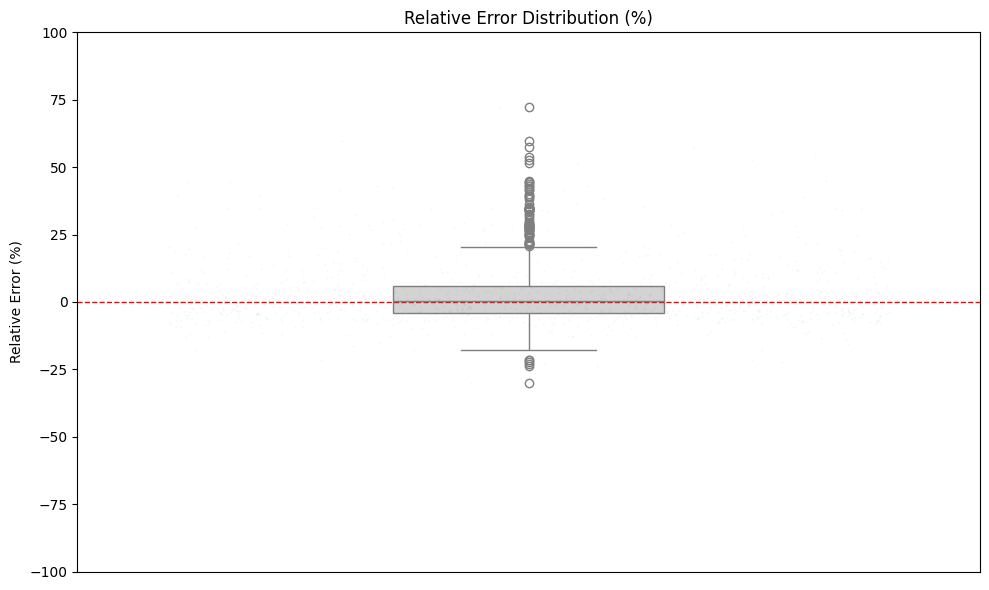

In [32]:
relative_error = relative_error.squeeze()
plt.figure(figsize=(10, 6))
sns.boxplot(y=relative_error, color='lightgray', width=0.3)
sns.stripplot(y=relative_error, color='black', alpha=0.03, jitter=0.4, size=1.5)

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Relative Error Distribution (%)')
plt.ylabel('Relative Error (%)')
plt.xticks([])
plt.ylim(-100, 100)
plt.tight_layout()
plt.show()


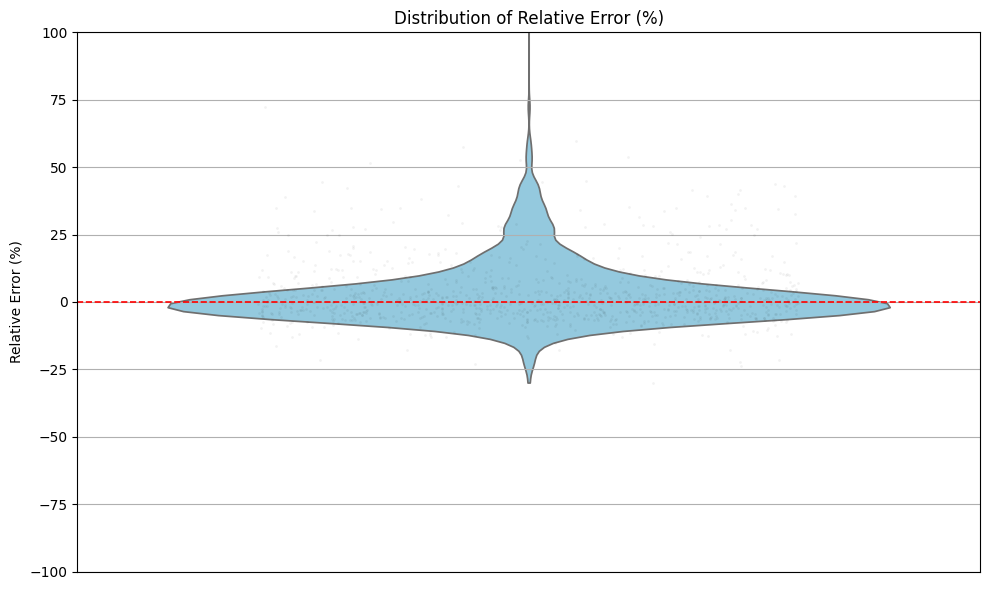

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(10, 6))
sns.violinplot(y=relative_error, inner=None, color='skyblue', cut=0)
sns.stripplot(y=relative_error, color='black', alpha=0.05, jitter=0.3, size=2)

plt.axhline(0, color='red', linestyle='--', linewidth=1.2)
plt.title('Distribution of Relative Error (%)')
plt.ylabel('Relative Error (%)')
plt.grid()
plt.xticks([])
plt.ylim(-100, 100)
plt.tight_layout()
plt.show()


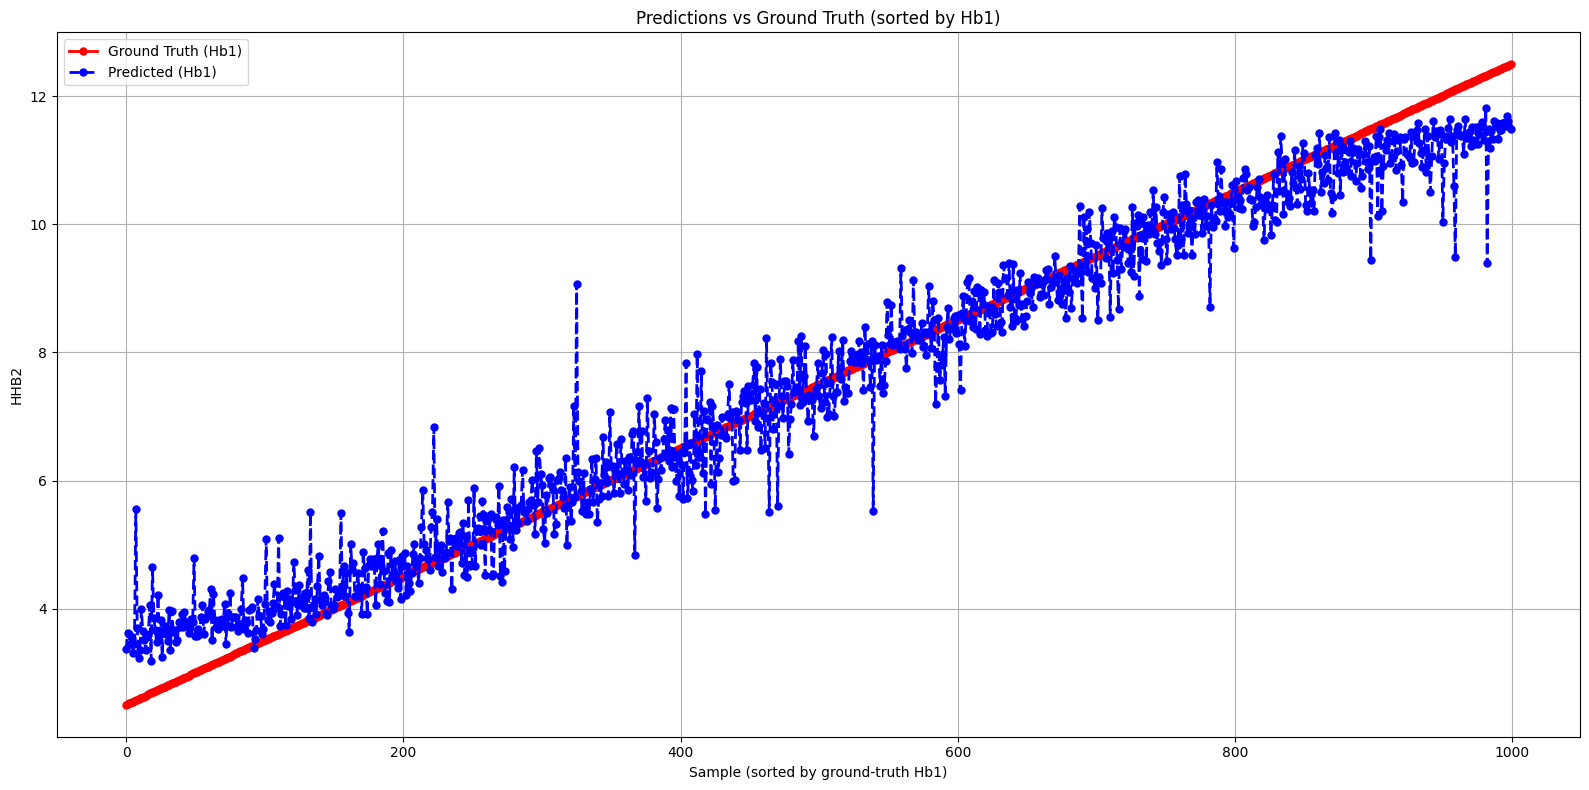

In [42]:
from sklearn.metrics import mean_squared_error

sorted_idx       = np.argsort(y_test_rescaled)         # indices that sort y_test
y_test_sorted    = y_test_rescaled[sorted_idx]
y_pred_sorted    = y_pred_rescaled[sorted_idx]

plt.figure(figsize=(16, 8))
plt.plot(y_test_sorted, 'r-o',  label='Ground Truth (Hb1)', linewidth=2, markersize=5)
plt.plot(y_pred_sorted, 'b--o', label='Predicted (Hb1)',   linewidth=2, markersize=5)
plt.xlabel('Sample (sorted by ground-truth Hb1)')
plt.ylabel('HHB2')
plt.title('Predictions vs Ground Truth (sorted by Hb1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


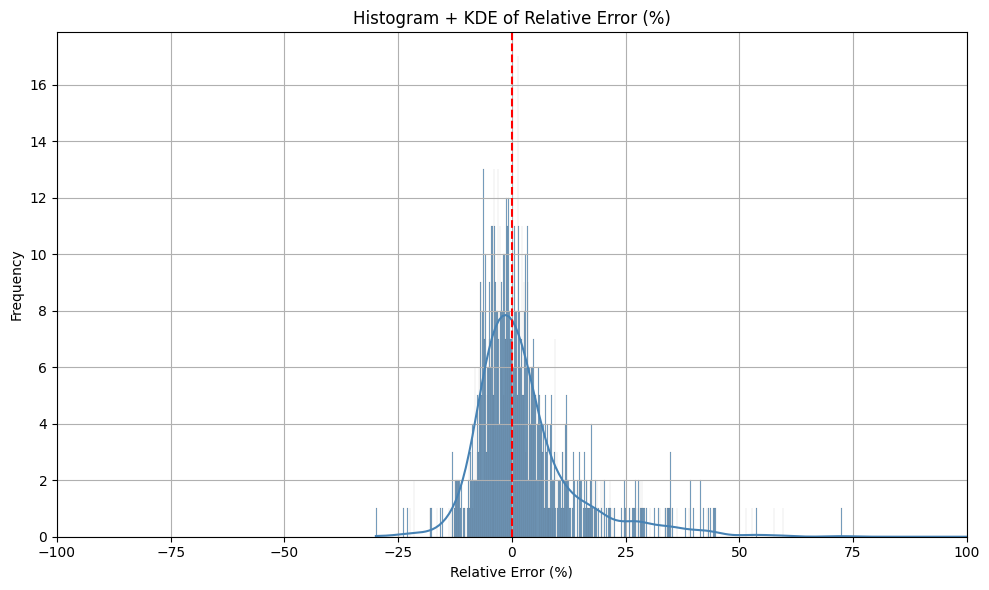

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(relative_error, kde=True, bins=1000, color='steelblue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Histogram + KDE of Relative Error (%)")
plt.xlabel("Relative Error (%)")
plt.ylabel("Frequency")
plt.grid()
plt.xlim(-100, 100)
plt.tight_layout()
plt.show()

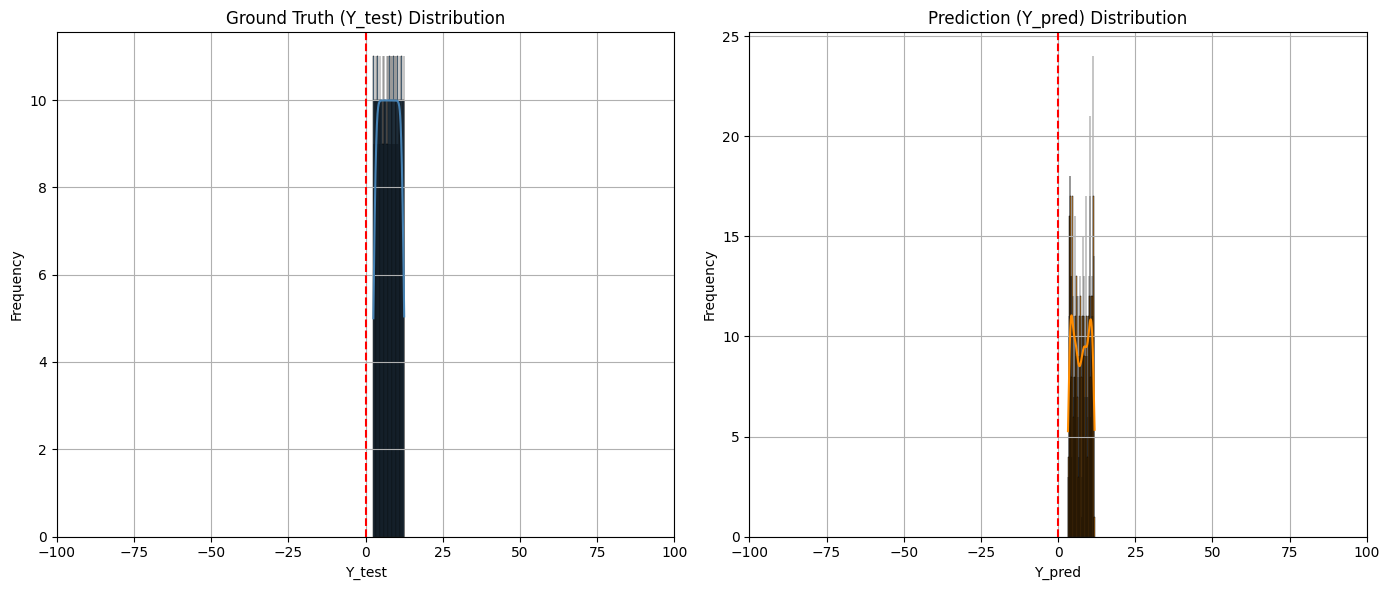

In [36]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(np.asarray(y_test_orig).ravel(), kde=True, bins=100, color='steelblue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Ground Truth (Y_test) Distribution")
plt.xlabel("Y_test")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim(-100, 100)

plt.subplot(1, 2, 2)
sns.histplot( np.asarray(y_pred_orig).ravel(), kde=True, bins=100, color='darkorange', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Prediction (Y_pred) Distribution")
plt.xlabel("Y_pred")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim(-100, 100)

plt.tight_layout()
plt.show()

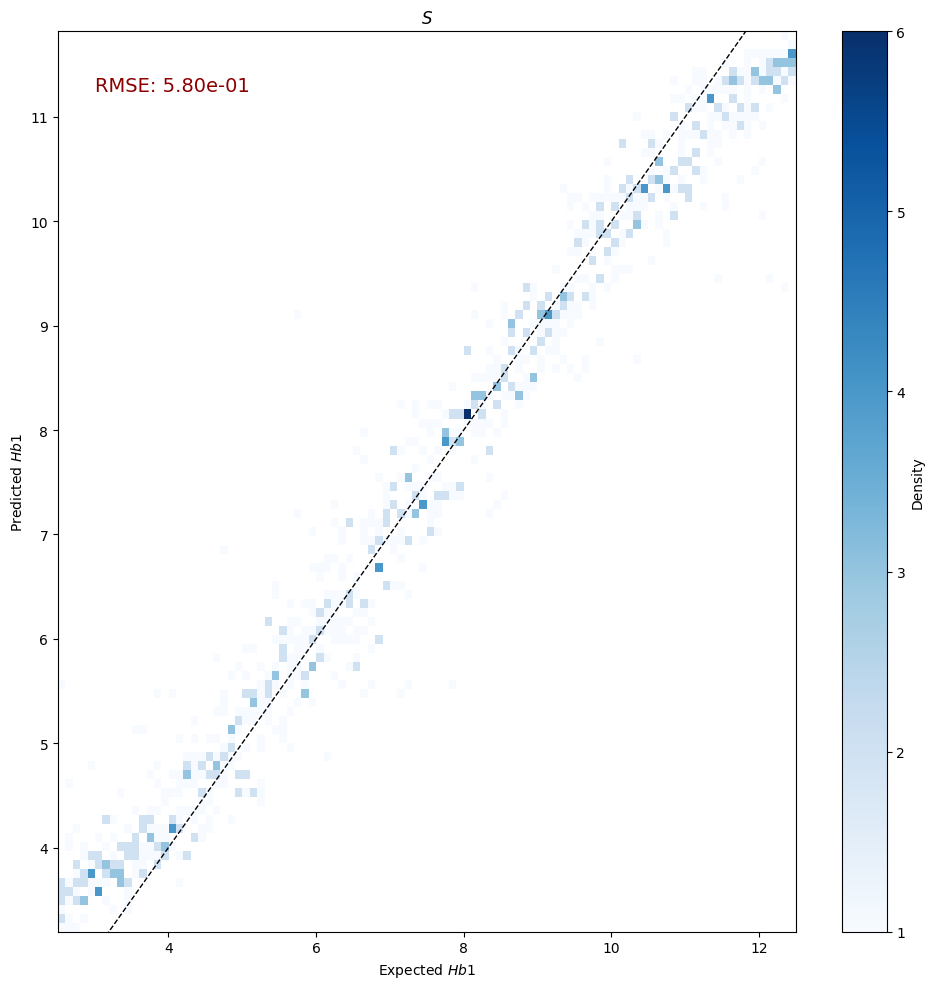

In [43]:
from sklearn.metrics import mean_squared_error
y_true = np.asarray(y_test_orig).ravel()
y_pred =np.asarray(y_pred_orig).ravel()
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
plt.figure(figsize=(10, 10))
plt.hist2d(y_true, y_pred, bins=100, cmap='Blues', cmin=1)
plt.plot([min(y_true), max(y_true)],
         [min(y_true), max(y_true)],
         'k--', lw=1)
plt.xlabel('Expected $Hb1$')
plt.ylabel('Predicted $Hb1$')
plt.title(r'$S$')
plt.text(0.05, 0.95, f'RMSE: {rmse:.2e}', color='darkred',
         fontsize=14, transform=plt.gca().transAxes, va='top')
plt.colorbar(label='Density')
plt.tight_layout()
plt.show()

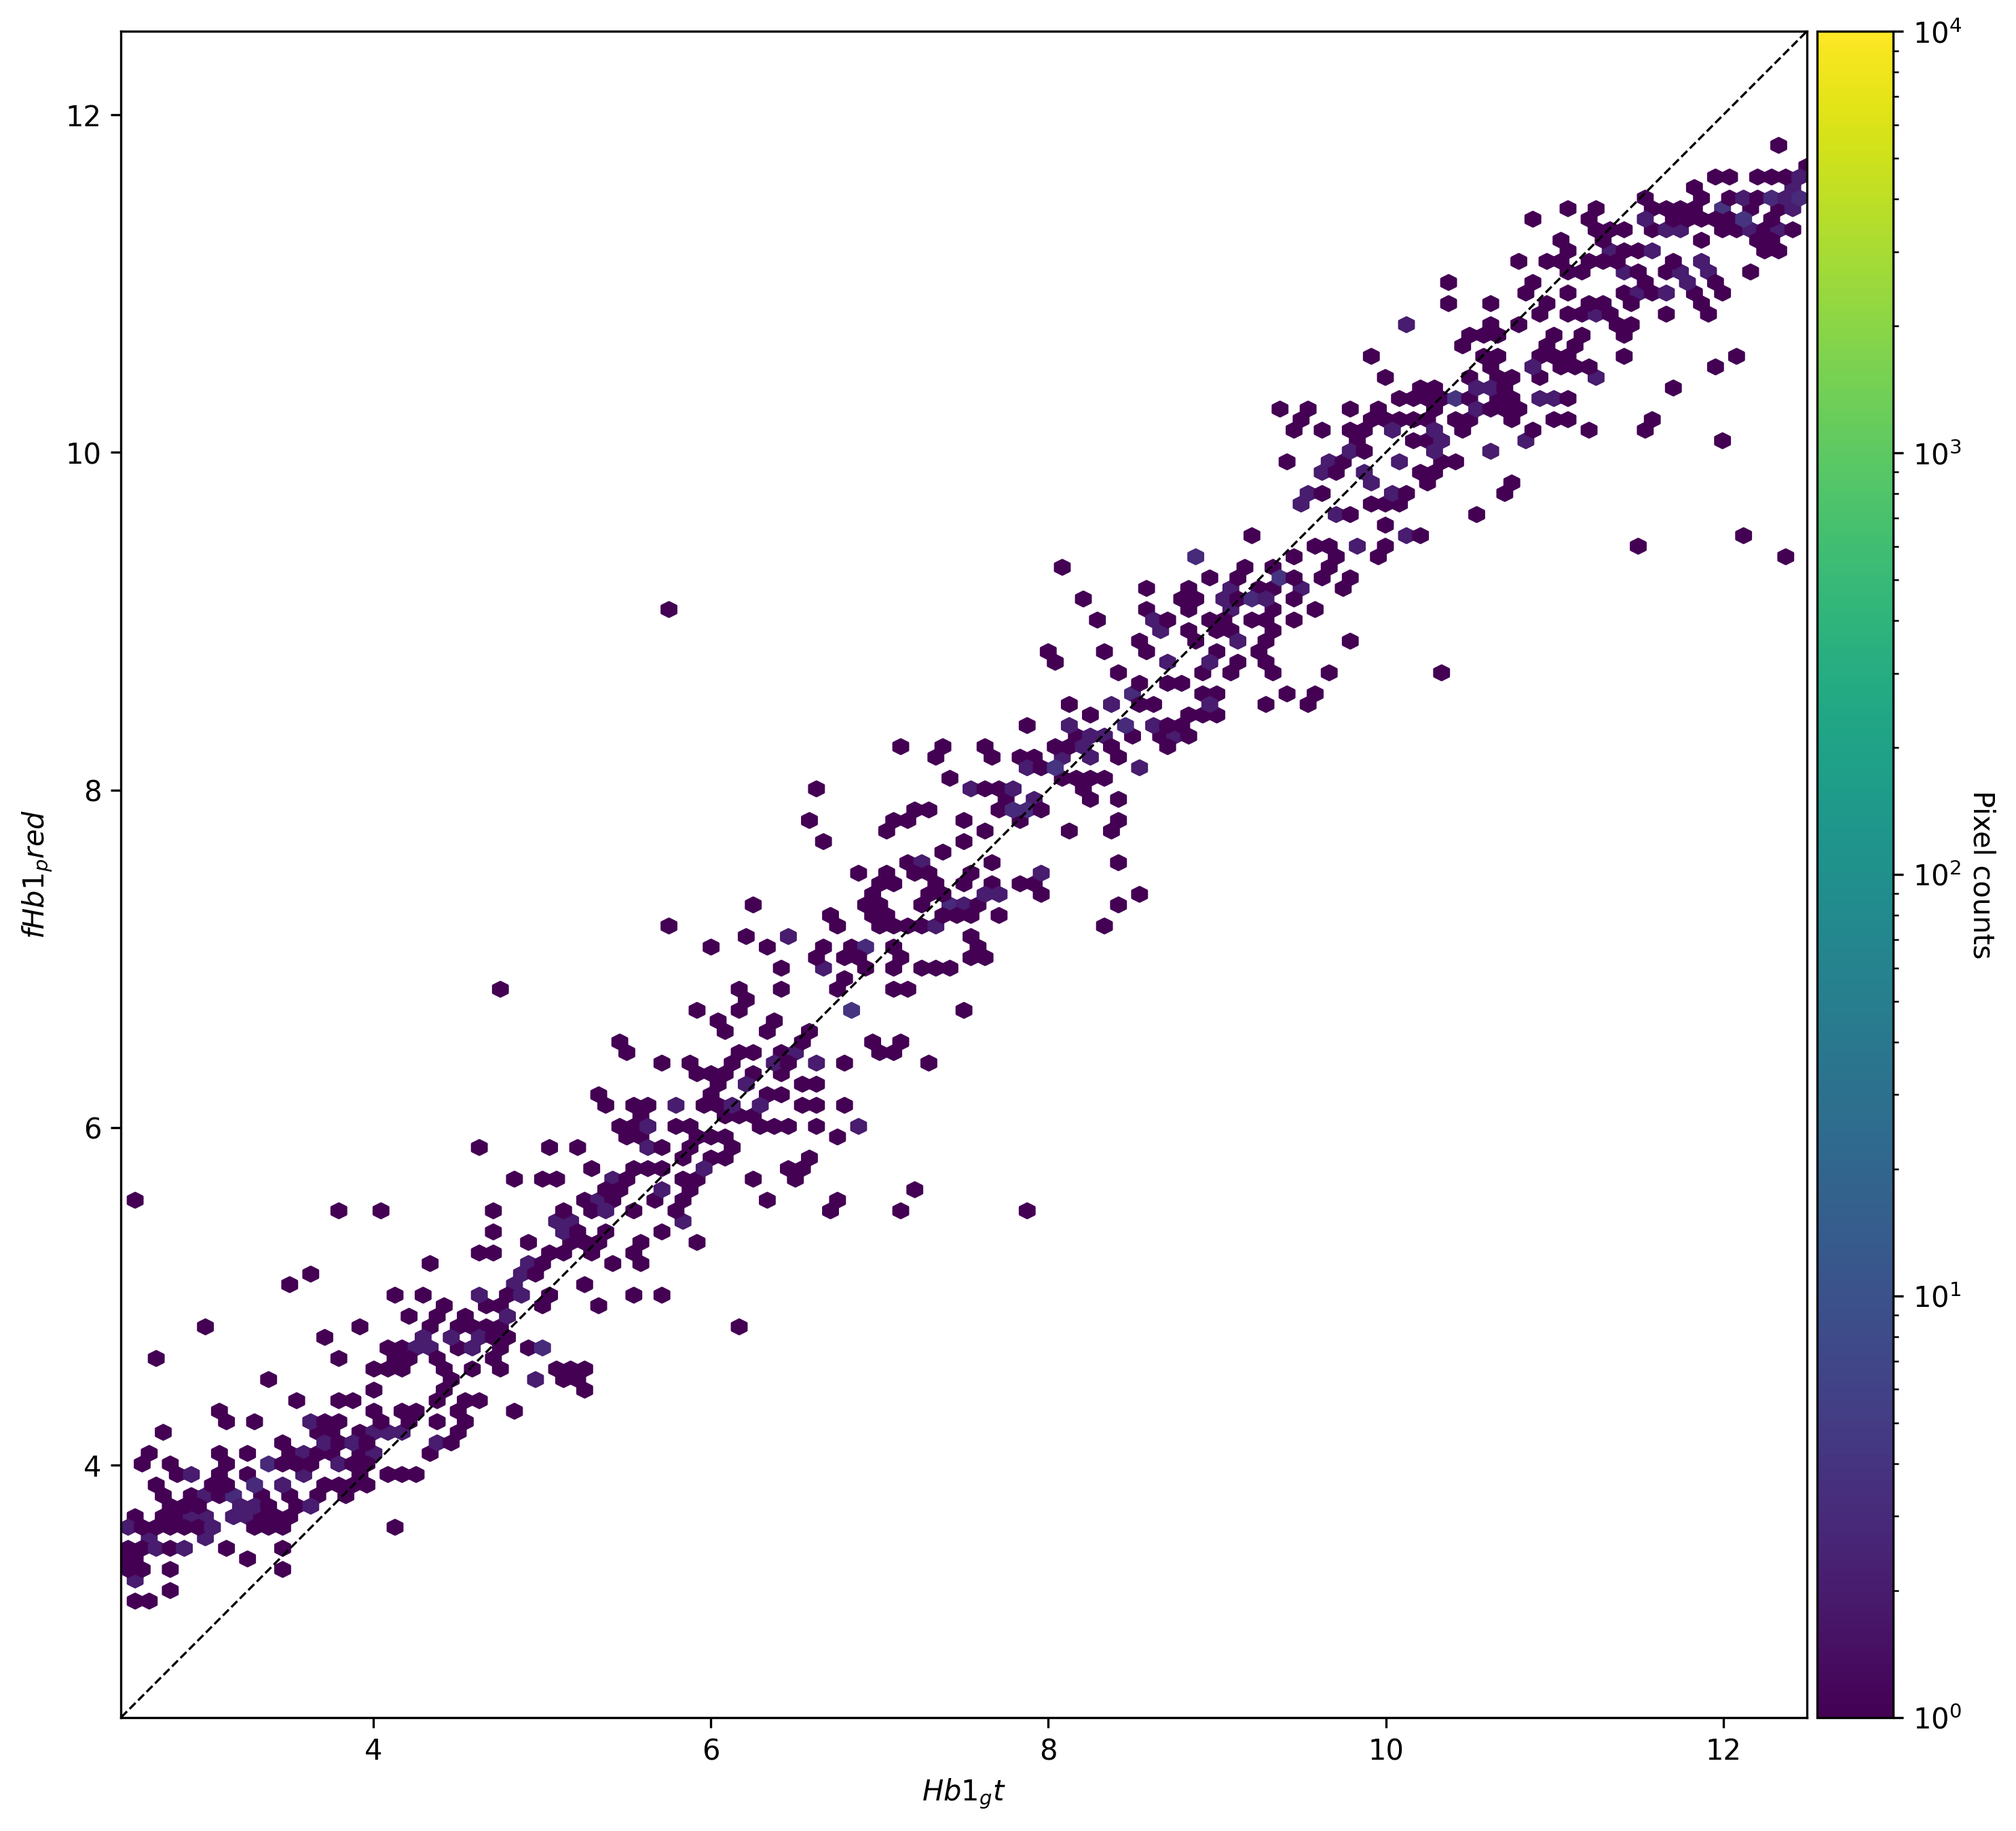

In [46]:

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

x = y_test_rescaled.ravel()
y = y_pred_rescaled.ravel()
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
hb = ax.hexbin(
        x, y, gridsize=120,
        cmap="viridis",
        norm=LogNorm(vmin=1, vmax=1e4)
      )

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4.5%", pad=0.05)  # width, gap
cb = fig.colorbar(hb, cax=cax)
cb.set_label("Pixel counts", rotation=270, labelpad=12)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
ax.plot(lims, lims, 'k--', linewidth=0.8)
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel(r"$Hb1_gt$")
ax.set_ylabel(r"$fHb1_pred$")
ax.grid(False)
fig.tight_layout()
plt.show()

In [39]:
eps = 1e-8
relative_error = (y_pred - y_true) / (y_true + eps) * 100
absolute_relative_error = np.abs(relative_error)
mre = np.mean(relative_error)
mape = np.mean(absolute_relative_error)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

Mean Absolute Percentage Error (MAPE): 7.6045%


In [40]:
lower, upper = np.percentile(relative_error, [16, 84])
print(f"68% CI of HHb₂ % error: {lower:.2f}% to {upper:.2f}%")

68% CI of HHb₂ % error: -5.83% to 10.85%
